# Benchmarking the surface code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import stim
from pymatching import Matching

from hypergraph_decomposition import decompose_dem, from_dem_to_stim, from_stim_to_dem

In [2]:
NUM_ROUNDS = np.arange(2, 50, 6)
DISTANCES = [3]
AFTER_CLIFFORD_DEPOLS = [0.003]
NUM_SHOTS = 1_000_000

============[d=3 p=0.003]=============
round=2   time-to-decompose=0.020   time-to-decode=0.060
d_circ=3 d_circ_stim=3
round=8   time-to-decompose=0.045   time-to-decode=0.253
d_circ=3 d_circ_stim=3
round=14   time-to-decompose=0.096   time-to-decode=0.512
d_circ=3 d_circ_stim=3
round=20   time-to-decompose=0.163   time-to-decode=0.802
d_circ=3 d_circ_stim=3
round=26   time-to-decompose=0.174   time-to-decode=0.858
d_circ=3 d_circ_stim=3
round=32   time-to-decompose=0.176   time-to-decode=1.101
d_circ=3 d_circ_stim=3
round=38   time-to-decompose=0.239   time-to-decode=1.381
d_circ=3 d_circ_stim=3
round=44   time-to-decompose=0.278   time-to-decode=1.609
d_circ=3 d_circ_stim=3


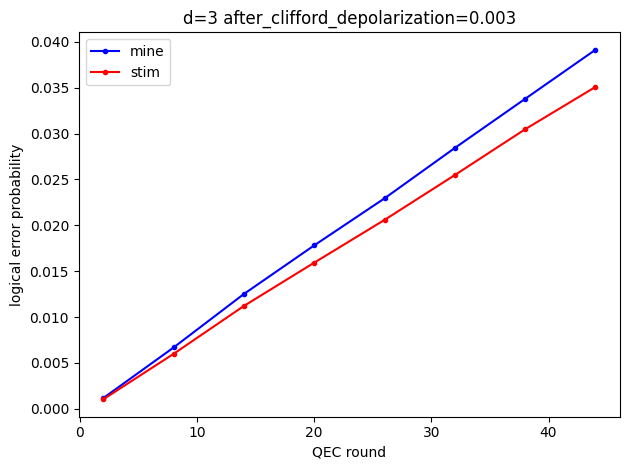

In [3]:
list_log_prob = []
list_log_prob_stim = []

for after_clifford_depolarization in AFTER_CLIFFORD_DEPOLS:
    for distance in DISTANCES:
        print(f"============[d={distance} p={after_clifford_depolarization}]=============")
        list_log_prob = []
        list_log_prob_stim = []
        for rounds in NUM_ROUNDS:
            print(f"round={rounds} \r", end="") 
            circuit = stim.Circuit.generated(code_task="surface_code:rotated_memory_z", distance=distance, rounds=rounds, 
                                             after_clifford_depolarization=after_clifford_depolarization)
        
            t0 = time.time()
            dem = from_stim_to_dem(circuit.detector_error_model())
            decom_dem = decompose_dem(dem, verbose=False)
            decom = from_dem_to_stim(decom_dem)
            t1 = time.time()
            print(f"round={rounds}   time-to-decompose={(t1 - t0):0.3f}\r", end="") 
        
            decom_stim = circuit.detector_error_model(decompose_errors=True)
        
            sampler = circuit.compile_detector_sampler()
            defects, log_flips = sampler.sample(shots=NUM_SHOTS, separate_observables=True)
        
            MWPM = Matching(decom)
            MWPM_stim = Matching(decom_stim)
        
            t2 = time.time()
            predictions = MWPM.decode_batch(defects)
            print(f"round={rounds}   time-to-decompose={(t1 - t0):0.3f}   time-to-decode={(time.time() - t2):0.3f}")
            print(f"d_circ={len(decom.shortest_graphlike_error())} d_circ_stim={len(decom_stim.shortest_graphlike_error())}")
            predictions_stim = MWPM_stim.decode_batch(defects)
            
            log_prob = np.average(predictions != log_flips)
            log_prob_stim = np.average(predictions_stim != log_flips)
        
            list_log_prob.append(log_prob)
            list_log_prob_stim.append(log_prob_stim)
            
        plt.plot(NUM_ROUNDS, list_log_prob, ".-", color="blue", label="mine")
        plt.plot(NUM_ROUNDS, list_log_prob_stim, ".-", color="red", label="stim")
        plt.legend()
        plt.xlabel("QEC round")
        plt.ylabel("logical error probability")
        plt.title(f"d={distance} after_clifford_depolarization={after_clifford_depolarization}")
        plt.tight_layout()
        plt.show()

In [4]:
my_edges = [(e[0], e[1]) for e in MWPM.edges()]
stim_edges = [(e[0], e[1]) for e in MWPM_stim.edges()]
set(my_edges) == set(stim_edges)

False

In [5]:
len(set(my_edges).symmetric_difference(stim_edges))

771

In [6]:
len(set(my_edges).difference(stim_edges)), len(set(stim_edges).difference(my_edges))

(0, 771)

This means that stim's detector error model has more faults than my detector error model. In particular, stim's detector error model is mine but with 771 more faults

In [7]:
counter = 1
for e1, e2 in sorted(my_edges, key=lambda x: x[0]):
    if e2 is None:
        # boundary edge
        p1 = MWPM.get_boundary_edge_data(e1)["error_probability"]
        p2 = MWPM_stim.get_boundary_edge_data(e1)["error_probability"]
        if p1 - p2 > 1e-8:
            print(f"{counter} edge=({e1}, None)", p1, p2)
            counter += 1
    else:
        # edge
        # boundary edge
        p1 = MWPM.get_edge_data(e1, e2)["error_probability"]
        p2 = MWPM_stim.get_edge_data(e1, e2)["error_probability"]
        if p1 - p2 > 1e-8:
            print(f"{counter} edge=({e1}, {e2})", p1, p2)
            counter += 1

1 edge=(0, None) 0.002398078974768928 0.0015999999999997984
2 edge=(1, None) 0.007948963578022775 0.006369345483570401
3 edge=(2, None) 0.00873687607136495 0.006369345483570403
4 edge=(2, 3) 0.003990405122049467 0.0031948799999995977
5 edge=(2, 5) 0.003990405122049467 0.003194879999999598
6 edge=(3, 10) 0.0023980789747689284 0.0015999999999997984
7 edge=(4, None) 0.02040837274194417 0.014996484684467638
8 edge=(5, None) 0.015771555112116087 0.01265755384336265
9 edge=(6, None) 0.034045128715052275 0.02117479458404916
10 edge=(7, 10) 0.0047846563839994 0.003990405122049468
11 edge=(7, None) 0.006369345483570402 0.0047846563839994
12 edge=(8, None) 0.007159787391016402 0.0047846563839994
13 edge=(9, None) 0.03404512871505226 0.02117479458404916
14 edge=(10, None) 0.01654694143003377 0.012657553843362644
15 edge=(11, None) 0.020408372741944174 0.011877499052815757
16 edge=(12, None) 0.020408372741944174 0.006369345483570403
17 edge=(13, None) 0.016546941430033775 0.012657553843362652
18 e

In [8]:
edges = set(my_edges).symmetric_difference(stim_edges)
edges = list(edges)
edges = sorted(edges, key=lambda x: x[0])

for e1, e2 in edges:
    if e2 is None:
        p1 = MWPM_stim.get_boundary_edge_data(e1)["error_probability"]
        print(f"edge=({e1}, None)", p1)
    else:
        p1 = MWPM_stim.get_edge_data(e1, e2)["error_probability"]
        print(f"edge=({e1}, {e2})", p1)

edge=(0, 8) 0.0008006410260524976
edge=(1, 5) 0.0015999999999997986
edge=(2, 8) 0.0008006410260524976
edge=(2, 10) 0.0015999999999997986
edge=(3, 5) 0.0008006410260524978
edge=(3, 7) 0.0008006410260524978
edge=(4, 12) 0.004786248708100399
edge=(4, 6) 0.0008006410260524978
edge=(5, 13) 0.0015999999999997982
edge=(6, 9) 0.004784656383999398
edge=(6, 12) 0.0023980789747689284
edge=(6, 14) 0.005579225599999705
edge=(7, 13) 0.0008006410260524976
edge=(7, 15) 0.0008006410260524978
edge=(8, 16) 0.0008006410260524978
edge=(9, 11) 0.0008006410260524978
edge=(9, 14) 0.0015999999999997986
edge=(9, 17) 0.005579225599999706
edge=(9, 12) 0.0008006410260524976
edge=(10, 16) 0.0008006410260524976
edge=(10, 18) 0.0015999999999997982
edge=(11, 14) 0.0008006410260524976
edge=(11, 17) 0.0023980789747689284
edge=(11, 19) 0.004786248708100399
edge=(12, 14) 0.0015999999999997986
edge=(12, 20) 0.004786248708100399
edge=(13, 21) 0.0015999999999997982
edge=(14, 17) 0.006369345483570403
edge=(14, 20) 0.002398078

The difference between the performance between stim's decomposition and mine is that stim graph has more weight-2 edges than mine. This is because Algorithm 3 tries to decompose all weight-2 edges into weight-1 edges. 

I'll try to keep the weight-2 edges as primitives for Algorithm 3

In [9]:
# not decomposing the weight-2 edges

from copy import deepcopy

import pymatching
import numpy as np

from hypergraph_decomposition.stim_tools import from_dem_to_stim
from hypergraph_decomposition.detector_error_model import DEM, xor, multiple_xor, g
from hypergraph_decomposition.decomposition import from_pymatching_edges_to_dem_id

def decompose_dem_edges(dem: DEM, verbose=True, ignore_logical_error=False) -> DEM:
    # Step 1: split the DEM into primitive and non-primitive faults
    for id_ in dem.ids:
        detectors = dem.detectors[id_]
        if len(detectors) <= 2:
            dem.add_primitive(id_)

    # Step 2: for every hyperedge run MWPM to obtain the most probable decomposition
    primtive_dem = dem.get_primitive_graph()
    stim_primitive_dem = from_dem_to_stim(primtive_dem)
    MWPM_prim = pymatching.Matching(stim_primitive_dem)

    for hyper in dem.get_undecomposed_faults():
        det_ids = dem.detectors[hyper]
        det_vec = np.zeros(MWPM_prim.num_detectors, dtype=bool)
        det_vec[det_ids] = 1
        errors = True
        counter = 0
        MAX_COUNTER = 20
        prob_factor = 0.5
        while (errors is not None) and (counter < MAX_COUNTER):
            edges = MWPM_prim.decode_to_edges_array(det_vec)
            decomposition = from_pymatching_edges_to_dem_id(edges, dem)
            errors = dem.add_decomposition(
                hyper,
                decomposition,
                ignore_logical_error=ignore_logical_error,
                verbose=verbose,
            )
            counter += 1
            if errors is not None:
                dem_copy = deepcopy(dem)
                for id_ in decomposition:
                    dem_copy.probs[id_] *= prob_factor
                primtive_dem = dem_copy.get_primitive_graph()
                stim_primitive_dem = from_dem_to_stim(primtive_dem)
                MWPM_prim = pymatching.Matching(stim_primitive_dem)

        if counter != 0:
            primtive_dem = dem.get_primitive_graph()
            stim_primitive_dem = from_dem_to_stim(primtive_dem)
            MWPM_prim = pymatching.Matching(stim_primitive_dem)
        elif counter == MAX_COUNTER:
            raise ValueError("Reached max number of iterations for decomposition")

    return dem


============[d=3 p=0.003]=============
round=2   time-to-decompose=0.063   time-to-decode=0.094
d_circ=3 d_circ_stim=3
round=8   time-to-decompose=2.083   time-to-decode=0.610
d_circ=3 d_circ_stim=3
round=14   time-to-decompose=7.890   time-to-decode=1.202
d_circ=3 d_circ_stim=3
round=20   time-to-decompose=16.631   time-to-decode=1.770
d_circ=3 d_circ_stim=3
round=26   time-to-decompose=31.578   time-to-decode=2.466
d_circ=3 d_circ_stim=3
round=32   time-to-decompose=48.409   time-to-decode=3.122
d_circ=3 d_circ_stim=3
round=38   time-to-decompose=69.362   time-to-decode=3.492
d_circ=3 d_circ_stim=3
round=44   time-to-decompose=92.185   time-to-decode=4.174
d_circ=3 d_circ_stim=3


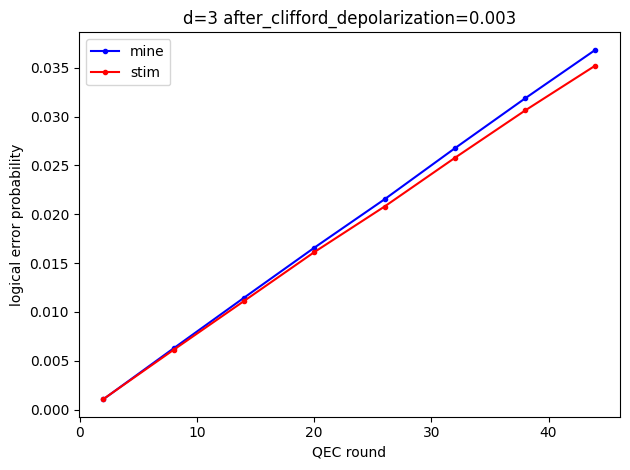

In [11]:
list_log_prob = []
list_log_prob_stim = []

for after_clifford_depolarization in AFTER_CLIFFORD_DEPOLS:
    for distance in DISTANCES:
        print(f"============[d={distance} p={after_clifford_depolarization}]=============")
        list_log_prob = []
        list_log_prob_stim = []
        for rounds in NUM_ROUNDS:
            print(f"round={rounds} \r", end="") 
            circuit = stim.Circuit.generated(code_task="surface_code:rotated_memory_z", distance=distance, rounds=rounds, 
                                             after_clifford_depolarization=after_clifford_depolarization)
        
            t0 = time.time()
            dem = from_stim_to_dem(circuit.detector_error_model())
            decom_dem = decompose_dem_edges(dem, verbose=False, ignore_logical_error=True)
            decom = from_dem_to_stim(decom_dem)
            t1 = time.time()
            print(f"round={rounds}   time-to-decompose={(t1 - t0):0.3f}\r", end="") 
        
            decom_stim = circuit.detector_error_model(decompose_errors=True)
        
            sampler = circuit.compile_detector_sampler()
            defects, log_flips = sampler.sample(shots=NUM_SHOTS, separate_observables=True)
        
            MWPM = Matching(decom)
            MWPM_stim = Matching(decom_stim)
        
            t2 = time.time()
            predictions = MWPM.decode_batch(defects)
            print(f"round={rounds}   time-to-decompose={(t1 - t0):0.3f}   time-to-decode={(time.time() - t2):0.3f}")
            print(f"d_circ={len(decom.shortest_graphlike_error())} d_circ_stim={len(decom_stim.shortest_graphlike_error())}")
            predictions_stim = MWPM_stim.decode_batch(defects)
            
            log_prob = np.average(predictions != log_flips)
            log_prob_stim = np.average(predictions_stim != log_flips)
        
            list_log_prob.append(log_prob)
            list_log_prob_stim.append(log_prob_stim)
            
        plt.plot(NUM_ROUNDS, list_log_prob, ".-", color="blue", label="mine")
        plt.plot(NUM_ROUNDS, list_log_prob_stim, ".-", color="red", label="stim")
        plt.legend()
        plt.xlabel("QEC round")
        plt.ylabel("logical error probability")
        plt.title(f"d={distance} after_clifford_depolarization={after_clifford_depolarization}")
        plt.tight_layout()
        plt.show()

I had to change the code of the decomposition functin because if I do not decompose the weight-2 edges into weight-1 boundary edges then there are issues of decompositions not matching the logical effect (the error was for a weight-4 hyperedge). I changed the code so that now it searches several times until it finds a correct decomposition. One issue is that it is much slower. However, I get better performance. 

In [12]:
my_edges = [(e[0], e[1]) for e in MWPM.edges()]
stim_edges = [(e[0], e[1]) for e in MWPM_stim.edges()]
set(my_edges) == set(stim_edges)

False

In [13]:
len(set(my_edges).symmetric_difference(stim_edges))

520

In [14]:
len(set(my_edges).difference(stim_edges)), len(set(stim_edges).difference(my_edges))

(520, 0)

In [16]:
counter = 1
for e1, e2 in sorted(stim_edges, key=lambda x: x[0]):
    if e2 is None:
        # boundary edge
        p1 = MWPM.get_boundary_edge_data(e1)["error_probability"]
        p2 = MWPM_stim.get_boundary_edge_data(e1)["error_probability"]
        if p1 - p2 > 1e-8:
            print(f"{counter} edge=({e1}, None)", p1, p2)
            counter += 1
    else:
        # edge
        # boundary edge
        p1 = MWPM.get_edge_data(e1, e2)["error_probability"]
        p2 = MWPM_stim.get_edge_data(e1, e2)["error_probability"]
        if p1 - p2 > 1e-8:
            print(f"{counter} edge=({e1}, {e2})", p1, p2)
            counter += 1

1 edge=(0, 8) 0.0015999999999997982 0.0008006410260524976
2 edge=(1, 5) 0.0031948799999995973 0.0015999999999997986
3 edge=(2, 8) 0.0015999999999997986 0.0008006410260524976
4 edge=(2, 10) 0.003194879999999598 0.0015999999999997986
5 edge=(3, 5) 0.0015999999999997984 0.0008006410260524978
6 edge=(3, 7) 0.0015999999999997984 0.0008006410260524978
7 edge=(4, 12) 0.0055792255999997055 0.004786248708100399
8 edge=(5, 13) 0.002597398958853931 0.0015999999999997982
9 edge=(6, 9) 0.005775682202882206 0.004784656383999398
10 edge=(6, 14) 0.007161372078079506 0.005579225599999705
11 edge=(7, 13) 0.0014002803365721686 0.0008006410260524976
12 edge=(7, 15) 0.0015999999999997984 0.0008006410260524978
13 edge=(8, 16) 0.0015999999999997984 0.0008006410260524978
14 edge=(9, 12) 0.0012004806411542502 0.0008006410260524976
15 edge=(9, 17) 0.007161372078079506 0.005579225599999706
16 edge=(10, 16) 0.0014002803365721686 0.0008006410260524976
17 edge=(10, 18) 0.003194879999999598 0.0015999999999997982
18 

In [18]:
edges = set(my_edges).symmetric_difference(stim_edges)
edges = list(edges)
edges = sorted(edges, key=lambda x: x[0])

for e1, e2 in edges:
    if e2 is None:
        p1 = MWPM.get_boundary_edge_data(e1)["error_probability"]
        print(f"edge=({e1}, None)", p1)
    else:
        p1 = MWPM.get_edge_data(e1, e2)["error_probability"]
        print(f"edge=({e1}, {e2})", p1)

edge=(1, 4) 0.002398078974768928
edge=(2, 6) 0.00020028056129117733
edge=(2, 9) 0.0015999999999997982
edge=(3, 6) 0.0008006410260524976
edge=(4, 5) 0.002398078974768928
edge=(5, 12) 0.0015999999999997984
edge=(5, 6) 0.0010006008816754938
edge=(6, 7) 0.0006006010421890037
edge=(6, 10) 0.00020028056129117733
edge=(6, 13) 0.00020028056129117733
edge=(7, 14) 0.0008006410260524976
edge=(8, 9) 0.0008006410260524976
edge=(9, 16) 0.0006006010421890037
edge=(9, 10) 0.0010006008816754938
edge=(10, 11) 0.003194879999999598
edge=(10, 17) 0.00020028056129117733
edge=(11, 18) 0.0010006008816754938
edge=(12, 13) 0.0021986791188537977
edge=(13, 14) 0.00020028056129117733
edge=(13, 20) 0.0010006008816754938
edge=(14, 15) 0.0008006410260524976
edge=(14, 21) 0.00020028056129117733
edge=(15, 22) 0.0008006410260524976
edge=(16, 17) 0.0008006410260524976
edge=(17, 18) 0.00020028056129117733
edge=(17, 24) 0.0008006410260524976
edge=(18, 19) 0.001000600881675494
edge=(18, 25) 0.00020028056129117733
edge=(19, 

I try to remove the primitives, because now my DEM has more edges than stim's DEM

In [30]:
from copy import deepcopy

import pymatching
import numpy as np

from hypergraph_decomposition.stim_tools import from_dem_to_stim
from hypergraph_decomposition.detector_error_model import DEM, xor, multiple_xor, g
from hypergraph_decomposition.decomposition import from_pymatching_edges_to_dem_id

def decompose_dem_edges(dem: DEM, verbose=True, ignore_logical_error=False) -> DEM:
    # Step 1: split the DEM into primitive and non-primitive faults
    for id_ in dem.ids:
        detectors = dem.detectors[id_]
        if len(detectors) <= 2:
            dem.add_primitive(id_)

    # Step 2: for every hyperedge run MWPM to obtain the most probable decomposition
    primtive_dem = dem.get_primitive_graph()
    stim_primitive_dem = from_dem_to_stim(primtive_dem)
    MWPM_prim = pymatching.Matching(stim_primitive_dem)

    for hyper in dem.get_undecomposed_faults():
        det_ids = dem.detectors[hyper]
        det_vec = np.zeros(MWPM_prim.num_detectors, dtype=bool)
        det_vec[det_ids] = 1
        errors = True
        counter = 0
        MAX_COUNTER = 20
        prob_factor = 0.5
        while (errors is not None) and (counter < MAX_COUNTER):
            edges = MWPM_prim.decode_to_edges_array(det_vec)
            decomposition = from_pymatching_edges_to_dem_id(edges, dem)
            errors = dem.add_decomposition(
                hyper,
                decomposition,
                ignore_logical_error=ignore_logical_error,
                verbose=verbose,
            )
            counter += 1
            if errors is not None:
                dem_copy = deepcopy(dem)
                for id_ in decomposition:
                    dem_copy.probs[id_] *= prob_factor
                    dem.primitives.remove(id_)
                    del dem.prim_det_to_id[tuple(dem.detectors[id_])]
                    assert len(dem.detectors[id_]) <= 2
                    #dem.undecomposed[id_] = True
                primtive_dem = dem_copy.get_primitive_graph()
                stim_primitive_dem = from_dem_to_stim(primtive_dem)
                MWPM_prim = pymatching.Matching(stim_primitive_dem)

        if counter != 0:
            primtive_dem = dem.get_primitive_graph()
            stim_primitive_dem = from_dem_to_stim(primtive_dem)
            MWPM_prim = pymatching.Matching(stim_primitive_dem)
        elif counter == MAX_COUNTER:
            raise ValueError("Reached max number of iterations for decomposition")

    return dem

============[d=3 p=0.003]=============
round=2   time-to-decompose=0.047   time-to-decode=0.100
d_circ=3 d_circ_stim=3
round=8   time-to-decompose=1.683   time-to-decode=0.637
d_circ=3 d_circ_stim=3
round=14   time-to-decompose=5.734   time-to-decode=1.154
d_circ=3 d_circ_stim=3
round=20   time-to-decompose=13.100   time-to-decode=1.822
d_circ=3 d_circ_stim=3
round=26   time-to-decompose=23.460   time-to-decode=2.349
d_circ=3 d_circ_stim=3
round=32   time-to-decompose=37.133   time-to-decode=2.895
d_circ=3 d_circ_stim=3
round=38   time-to-decompose=53.563   time-to-decode=3.702
d_circ=3 d_circ_stim=3
round=44   time-to-decompose=73.901   time-to-decode=4.172
d_circ=3 d_circ_stim=3


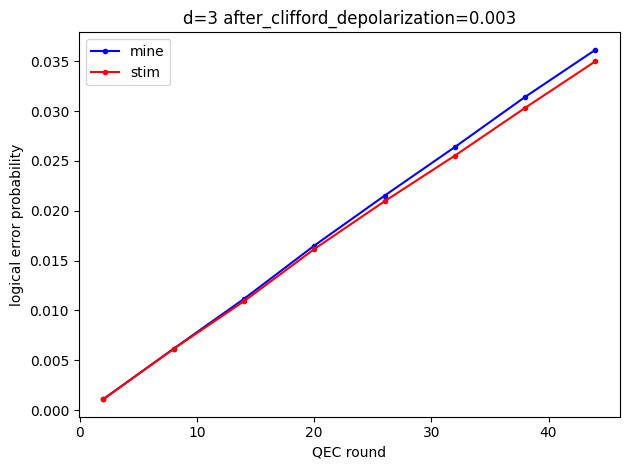

In [31]:
list_log_prob = []
list_log_prob_stim = []

for after_clifford_depolarization in AFTER_CLIFFORD_DEPOLS:
    for distance in DISTANCES:
        print(f"============[d={distance} p={after_clifford_depolarization}]=============")
        list_log_prob = []
        list_log_prob_stim = []
        for rounds in NUM_ROUNDS:
            print(f"round={rounds} \r", end="") 
            circuit = stim.Circuit.generated(code_task="surface_code:rotated_memory_z", distance=distance, rounds=rounds, 
                                             after_clifford_depolarization=after_clifford_depolarization)
        
            t0 = time.time()
            dem = from_stim_to_dem(circuit.detector_error_model())
            decom_dem = decompose_dem_edges(dem, verbose=False, ignore_logical_error=True)
            decom = from_dem_to_stim(decom_dem)
            t1 = time.time()
            print(f"round={rounds}   time-to-decompose={(t1 - t0):0.3f}\r", end="") 
        
            decom_stim = circuit.detector_error_model(decompose_errors=True)
        
            sampler = circuit.compile_detector_sampler()
            defects, log_flips = sampler.sample(shots=NUM_SHOTS, separate_observables=True)
        
            MWPM = Matching(decom)
            MWPM_stim = Matching(decom_stim)
        
            t2 = time.time()
            predictions = MWPM.decode_batch(defects)
            print(f"round={rounds}   time-to-decompose={(t1 - t0):0.3f}   time-to-decode={(time.time() - t2):0.3f}")
            print(f"d_circ={len(decom.shortest_graphlike_error())} d_circ_stim={len(decom_stim.shortest_graphlike_error())}")
            predictions_stim = MWPM_stim.decode_batch(defects)
            
            log_prob = np.average(predictions != log_flips)
            log_prob_stim = np.average(predictions_stim != log_flips)
        
            list_log_prob.append(log_prob)
            list_log_prob_stim.append(log_prob_stim)
            
        plt.plot(NUM_ROUNDS, list_log_prob, ".-", color="blue", label="mine")
        plt.plot(NUM_ROUNDS, list_log_prob_stim, ".-", color="red", label="stim")
        plt.legend()
        plt.xlabel("QEC round")
        plt.ylabel("logical error probability")
        plt.title(f"d={distance} after_clifford_depolarization={after_clifford_depolarization}")
        plt.tight_layout()
        plt.show()

I had to change the code of the decomposition functin because if I do not decompose the weight-2 edges into weight-1 boundary edges then there are issues of decompositions not matching the logical effect (the error was for a weight-4 hyperedge). I changed the code so that now it searches several times until it finds a correct decomposition. One issue is that it is much slower. However, I get better performance. 

In [32]:
my_edges = [(e[0], e[1]) for e in MWPM.edges()]
stim_edges = [(e[0], e[1]) for e in MWPM_stim.edges()]
set(my_edges) == set(stim_edges)

False

In [33]:
len(set(my_edges).symmetric_difference(stim_edges))

520

In [34]:
len(set(my_edges).difference(stim_edges)), len(set(stim_edges).difference(my_edges))

(520, 0)